The code below was taken from the link below, and may even have a prior source.
There are some additional commented notes added for clarification purposes.

https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

C:\Users\jkhanlian\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import handwritten training data set
#transform/clean

def load_data():
    
    #get MNIST hand written number dataset from curated keras datasets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    #normalize the pixel values
    #grayscale pixel values range from 0 (black) to 255 (white)
    #now all of our pixel values will range from -1 (black) to 1 (white)
    #normalizing input values is a practice done that seems to make training neural nets easier
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 60,000 training examples; one in each row; with 784 columns of unrolled pixel inputs
    x_train = x_train.reshape(60000, 784)
    
    return (x_train, y_train, x_test, y_test)

#run function to load data
(X_train, y_train, X_test, y_test)=load_data()

#verify shape of training data
print(X_train.shape)

#first training example 
#first set of pixel values that represent a picture of a hand written number
print(X_train[1,:])

(60000, 784)
[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.        

 -1.         -1.         -1.         -1.        ]


In [3]:
#Define the Adam Optimizer parameter for updating weights
#Adam is an adaptive-rate learning algorithm used in gradient descent 
#For each weight, Adam Optimizer averages over recent gradient calcs (RMSProp), and squared gradient calcs (second moments)
#...less tweak-up,tweak-down,tweak-up,tweak-down repeats for specific weight updates
#good for on-line and non-stationary settings
#Adam Optimizer also uses benefits of the Adagrad gradient descent technique
#good for sparse gradients

#not all parameters are defined/changed
#beta_1 is changed from a normal value of 0.9 (i.e. the moving average, or weight updates, fluctuate more)
#the learning rate has been changed from a default value of 0.001 (i.e. the updates are smaller)
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)
    #return Adam(lr=0.001, beta_1=0.7)


In [4]:
#input layer has 100 units (noise/seed)
#output size is 784 units (same dimension as the real images)

#to verify one of the parameter calculations
#number of weights going from an input layer with 100 nodes to a hidden layer of 256 nodes:
#256*(100+1) = 25856 (each node in the hidden layer is fully connected to each node in the input layer)
#the +1 is for the bias weight, a trainable parameter that is not multiplied by an input

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    #LeakyReLu's parameter 0.2 represents the slope of the line for values less than 0
    #the slope of the line for values greater than 0 is 1 (or the identity function)
    #notice this is a hyper-parameter, and does not add to the trainable parameter count
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #tanh is an activation fuction that will output something between -1 and 1, just like our normalized MNIST pixel data
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()

g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [5]:
#the input has 784 units (same dimension as the real images, and the generator neural net output)
#the output has 1 unit (we are only interested in a confidence of a yes/no decision)

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    #Dropout is a "regularization" technique that can prevent overfitting
    #it can be helpful for modeling the signal of the training data and not the noise
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()

d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
__________

In [6]:
#the GAN can be viewed as one giant neural network
#the first half of layers represent the generator, and second half of layers represent the discriminator
#but unlike a traditional supervised learning neural net...
#1) not all weights are trained/updated at once
#2a) real images that weren't feed forward are injected halfway up the network for the discriminator training 
#2b) in discriminator training, half the input are fake images generated by the first half of the neural net
#2c) the other half of inputs are real images that aren't fed forward, but still become inputs to the second half of the network
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    #binary cross-entropy cost function on one output unit
    #at some point, check the calculation that Keras generates 
    #Y = ground truth (0 or 1)
    #A = neural net likelihood prediction (between 0 and 1)
    #m = batch size 
    #Binary Cross-Entropy: -(1.0/m) * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) 
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image4 %d.png' %epoch)

Epoch 1


100%|██████████| 128/128 [00:33<00:00,  3.18it/s]


Epoch 2


100%|██████████| 128/128 [00:31<00:00,  4.43it/s]


Epoch 3


100%|██████████| 128/128 [00:30<00:00,  4.33it/s]


Epoch 4


100%|██████████| 128/128 [00:29<00:00,  4.22it/s]


Epoch 5


100%|██████████| 128/128 [00:29<00:00,  3.95it/s]


Epoch 6


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Epoch 7


100%|██████████| 128/128 [00:29<00:00,  3.94it/s]


Epoch 8


100%|██████████| 128/128 [00:29<00:00,  4.53it/s]


Epoch 9


100%|██████████| 128/128 [00:29<00:00,  4.43it/s]


Epoch 10


100%|██████████| 128/128 [00:29<00:00,  4.51it/s]


Epoch 11


100%|██████████| 128/128 [00:29<00:00,  4.24it/s]


Epoch 12


100%|██████████| 128/128 [00:29<00:00,  4.34it/s]


Epoch 13


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 14


100%|██████████| 128/128 [00:29<00:00,  4.25it/s]


Epoch 15


100%|██████████| 128/128 [00:29<00:00,  4.46it/s]


Epoch 16


100%|██████████| 128/128 [00:30<00:00,  4.50it/s]


Epoch 17


100%|██████████| 128/128 [00:29<00:00,  4.53it/s]


Epoch 18


100%|██████████| 128/128 [00:29<00:00,  4.22it/s]


Epoch 19


100%|██████████| 128/128 [00:29<00:00,  4.24it/s]


Epoch 20


100%|██████████| 128/128 [00:29<00:00,  4.30it/s]


Epoch 21


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 22


100%|██████████| 128/128 [00:29<00:00,  4.31it/s]


Epoch 23


100%|██████████| 128/128 [00:29<00:00,  4.25it/s]


Epoch 24


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 25


100%|██████████| 128/128 [00:29<00:00,  4.50it/s]


Epoch 26


100%|██████████| 128/128 [00:30<00:00,  4.47it/s]


Epoch 27


100%|██████████| 128/128 [00:29<00:00,  4.45it/s]


Epoch 28


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 29


100%|██████████| 128/128 [00:29<00:00,  4.25it/s]


Epoch 30


100%|██████████| 128/128 [00:29<00:00,  4.28it/s]


Epoch 31


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 32


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]


Epoch 33


100%|██████████| 128/128 [00:31<00:00,  4.23it/s]


Epoch 34


100%|██████████| 128/128 [00:32<00:00,  3.41it/s]


Epoch 35


100%|██████████| 128/128 [00:32<00:00,  4.24it/s]


Epoch 36


100%|██████████| 128/128 [00:32<00:00,  4.07it/s]


Epoch 37


100%|██████████| 128/128 [00:31<00:00,  3.68it/s]


Epoch 38


100%|██████████| 128/128 [00:32<00:00,  4.02it/s]


Epoch 39


100%|██████████| 128/128 [00:32<00:00,  4.14it/s]


Epoch 40


100%|██████████| 128/128 [00:32<00:00,  4.22it/s]


Epoch 41


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 42


100%|██████████| 128/128 [00:30<00:00,  4.39it/s]


Epoch 43


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 44


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 45


100%|██████████| 128/128 [00:29<00:00,  3.92it/s]


Epoch 46


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 47


100%|██████████| 128/128 [00:29<00:00,  4.06it/s]


Epoch 48


100%|██████████| 128/128 [00:30<00:00,  4.44it/s]


Epoch 49


100%|██████████| 128/128 [00:29<00:00,  4.40it/s]


Epoch 50


100%|██████████| 128/128 [00:29<00:00,  4.47it/s]


Epoch 51


100%|██████████| 128/128 [00:29<00:00,  4.16it/s]


Epoch 52


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 53


100%|██████████| 128/128 [00:30<00:00,  4.23it/s]


Epoch 54


100%|██████████| 128/128 [00:30<00:00,  3.95it/s]


Epoch 55


100%|██████████| 128/128 [00:34<00:00,  4.31it/s]


Epoch 56


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 57


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 58


100%|██████████| 128/128 [00:30<00:00,  4.37it/s]


Epoch 59


100%|██████████| 128/128 [00:29<00:00,  4.50it/s]


Epoch 60


100%|██████████| 128/128 [00:30<00:00,  4.42it/s]


Epoch 61


100%|██████████| 128/128 [00:29<00:00,  4.46it/s]


Epoch 62


100%|██████████| 128/128 [00:30<00:00,  4.42it/s]


Epoch 63


100%|██████████| 128/128 [00:30<00:00,  4.25it/s]


Epoch 64


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 65


100%|██████████| 128/128 [00:29<00:00,  4.19it/s]


Epoch 66


100%|██████████| 128/128 [00:29<00:00,  4.32it/s]


Epoch 67


100%|██████████| 128/128 [00:29<00:00,  4.28it/s]


Epoch 68


100%|██████████| 128/128 [00:29<00:00,  4.28it/s]


Epoch 69


100%|██████████| 128/128 [00:29<00:00,  4.39it/s]


Epoch 70


100%|██████████| 128/128 [00:30<00:00,  4.45it/s]


Epoch 71


100%|██████████| 128/128 [00:29<00:00,  4.35it/s]


Epoch 72


100%|██████████| 128/128 [00:30<00:00,  4.12it/s]


Epoch 73


100%|██████████| 128/128 [00:29<00:00,  4.32it/s]


Epoch 74


100%|██████████| 128/128 [00:30<00:00,  4.32it/s]


Epoch 75


100%|██████████| 128/128 [00:29<00:00,  4.16it/s]


Epoch 76


100%|██████████| 128/128 [00:29<00:00,  4.46it/s]


Epoch 77


100%|██████████| 128/128 [00:29<00:00,  4.51it/s]


Epoch 78


100%|██████████| 128/128 [00:30<00:00,  4.47it/s]


Epoch 79


100%|██████████| 128/128 [00:29<00:00,  4.15it/s]


Epoch 80


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 81


100%|██████████| 128/128 [00:29<00:00,  4.22it/s]


Epoch 82


100%|██████████| 128/128 [00:29<00:00,  4.23it/s]


Epoch 83


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Epoch 84


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 85


100%|██████████| 128/128 [00:29<00:00,  4.51it/s]


Epoch 86


100%|██████████| 128/128 [00:34<00:00,  4.19it/s]


Epoch 87


100%|██████████| 128/128 [00:34<00:00,  3.85it/s]


Epoch 88


100%|██████████| 128/128 [00:31<00:00,  4.32it/s]


Epoch 89


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 90


100%|██████████| 128/128 [00:29<00:00,  4.40it/s]


Epoch 91


100%|██████████| 128/128 [00:29<00:00,  4.33it/s]


Epoch 92


100%|██████████| 128/128 [00:29<00:00,  4.35it/s]


Epoch 93


100%|██████████| 128/128 [00:29<00:00,  4.09it/s]


Epoch 94


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 95


100%|██████████| 128/128 [00:29<00:00,  4.25it/s]


Epoch 96


100%|██████████| 128/128 [00:30<00:00,  4.26it/s]


Epoch 97


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 98


100%|██████████| 128/128 [00:29<00:00,  4.53it/s]


Epoch 99


100%|██████████| 128/128 [00:29<00:00,  4.45it/s]


Epoch 100


100%|██████████| 128/128 [00:29<00:00,  4.35it/s]


Epoch 101


100%|██████████| 128/128 [00:30<00:00,  4.49it/s]


Epoch 102


100%|██████████| 128/128 [00:30<00:00,  4.36it/s]


Epoch 103


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 104


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 105


100%|██████████| 128/128 [00:29<00:00,  4.19it/s]


Epoch 106


100%|██████████| 128/128 [00:30<00:00,  4.24it/s]


Epoch 107


100%|██████████| 128/128 [00:29<00:00,  4.26it/s]


Epoch 108


100%|██████████| 128/128 [00:29<00:00,  4.43it/s]


Epoch 109


100%|██████████| 128/128 [00:30<00:00,  3.88it/s]


Epoch 110


100%|██████████| 128/128 [00:31<00:00,  4.38it/s]


Epoch 111


100%|██████████| 128/128 [00:29<00:00,  4.40it/s]


Epoch 112


100%|██████████| 128/128 [00:30<00:00,  4.01it/s]


Epoch 113


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 114


100%|██████████| 128/128 [00:29<00:00,  3.95it/s]


Epoch 115


100%|██████████| 128/128 [00:29<00:00,  4.23it/s]


Epoch 116


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 117


100%|██████████| 128/128 [00:30<00:00,  4.44it/s]


Epoch 118


100%|██████████| 128/128 [00:30<00:00,  4.48it/s]


Epoch 119


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 120


100%|██████████| 128/128 [00:29<00:00,  4.18it/s]


Epoch 121


100%|██████████| 128/128 [00:30<00:00,  4.45it/s]


Epoch 122


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 123


100%|██████████| 128/128 [00:30<00:00,  4.26it/s]


Epoch 124


100%|██████████| 128/128 [00:29<00:00,  4.10it/s]


Epoch 125


100%|██████████| 128/128 [00:30<00:00,  4.18it/s]


Epoch 126


100%|██████████| 128/128 [00:29<00:00,  4.47it/s]


Epoch 127


100%|██████████| 128/128 [00:29<00:00,  4.49it/s]


Epoch 128


100%|██████████| 128/128 [00:29<00:00,  4.49it/s]


Epoch 129


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 130


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Epoch 131


100%|██████████| 128/128 [00:29<00:00,  4.30it/s]


Epoch 132


100%|██████████| 128/128 [00:29<00:00,  4.12it/s]


Epoch 133


100%|██████████| 128/128 [00:30<00:00,  4.22it/s]


Epoch 134


100%|██████████| 128/128 [00:29<00:00,  4.49it/s]


Epoch 135


100%|██████████| 128/128 [00:29<00:00,  4.44it/s]


Epoch 136


100%|██████████| 128/128 [00:29<00:00,  4.37it/s]


Epoch 137


100%|██████████| 128/128 [00:30<00:00,  4.26it/s]


Epoch 138


100%|██████████| 128/128 [00:29<00:00,  4.19it/s]


Epoch 139


100%|██████████| 128/128 [00:29<00:00,  4.24it/s]


Epoch 140


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 141


100%|██████████| 128/128 [00:31<00:00,  3.76it/s]


Epoch 142


100%|██████████| 128/128 [00:31<00:00,  4.27it/s]


Epoch 143


100%|██████████| 128/128 [00:31<00:00,  4.20it/s]


Epoch 144


100%|██████████| 128/128 [00:32<00:00,  4.17it/s]


Epoch 145


100%|██████████| 128/128 [00:31<00:00,  4.09it/s]


Epoch 146


100%|██████████| 128/128 [00:31<00:00,  4.47it/s]


Epoch 147


100%|██████████| 128/128 [00:30<00:00,  4.27it/s]


Epoch 148


100%|██████████| 128/128 [00:30<00:00,  4.45it/s]


Epoch 149


100%|██████████| 128/128 [00:30<00:00,  4.38it/s]


Epoch 150


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 151


100%|██████████| 128/128 [00:30<00:00,  4.22it/s]


Epoch 152


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 153


100%|██████████| 128/128 [00:30<00:00,  4.19it/s]


Epoch 154


100%|██████████| 128/128 [00:29<00:00,  4.24it/s]


Epoch 155


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Epoch 156


100%|██████████| 128/128 [00:29<00:00,  4.49it/s]


Epoch 157


100%|██████████| 128/128 [00:31<00:00,  4.18it/s]


Epoch 158


100%|██████████| 128/128 [00:30<00:00,  4.45it/s]


Epoch 159


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 160


100%|██████████| 128/128 [00:29<00:00,  4.17it/s]


Epoch 161


100%|██████████| 128/128 [00:30<00:00,  4.04it/s]


Epoch 162


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 163


100%|██████████| 128/128 [00:31<00:00,  2.91it/s]


Epoch 164


100%|██████████| 128/128 [00:31<00:00,  4.24it/s]


Epoch 165


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Epoch 166


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 167


100%|██████████| 128/128 [00:29<00:00,  4.52it/s]


Epoch 168


100%|██████████| 128/128 [00:29<00:00,  4.44it/s]


Epoch 169


100%|██████████| 128/128 [00:29<00:00,  4.50it/s]


Epoch 170


100%|██████████| 128/128 [00:29<00:00,  4.25it/s]


Epoch 171


100%|██████████| 128/128 [00:29<00:00,  4.24it/s]


Epoch 172


100%|██████████| 128/128 [00:30<00:00,  4.31it/s]


Epoch 173


100%|██████████| 128/128 [00:30<00:00,  4.26it/s]


Epoch 174


100%|██████████| 128/128 [00:29<00:00,  4.27it/s]


Epoch 175


100%|██████████| 128/128 [00:29<00:00,  4.49it/s]


Epoch 176


100%|██████████| 128/128 [00:31<00:00,  4.33it/s]


Epoch 177


100%|██████████| 128/128 [00:32<00:00,  4.47it/s]


Epoch 178


100%|██████████| 128/128 [00:29<00:00,  4.43it/s]


Epoch 179


100%|██████████| 128/128 [00:30<00:00,  4.36it/s]


Epoch 180


100%|██████████| 128/128 [00:30<00:00,  4.22it/s]


Epoch 181


100%|██████████| 128/128 [00:30<00:00,  4.54it/s]


Epoch 182


100%|██████████| 128/128 [00:30<00:00,  4.35it/s]


Epoch 183


100%|██████████| 128/128 [00:29<00:00,  4.11it/s]


Epoch 184


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Epoch 185


100%|██████████| 128/128 [00:30<00:00,  4.26it/s]


Epoch 186


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 187


100%|██████████| 128/128 [00:30<00:00,  4.51it/s]


Epoch 188


100%|██████████| 128/128 [00:29<00:00,  4.47it/s]


Epoch 189


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 190


100%|██████████| 128/128 [00:30<00:00,  4.30it/s]


Epoch 191


100%|██████████| 128/128 [00:29<00:00,  4.23it/s]


Epoch 192


100%|██████████| 128/128 [00:29<00:00,  4.24it/s]


Epoch 193


100%|██████████| 128/128 [00:30<00:00,  4.23it/s]


Epoch 194


100%|██████████| 128/128 [00:29<00:00,  4.13it/s]


Epoch 195


100%|██████████| 128/128 [00:30<00:00,  4.27it/s]


Epoch 196


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 197


100%|██████████| 128/128 [00:30<00:00,  4.47it/s]


Epoch 198


100%|██████████| 128/128 [00:29<00:00,  4.28it/s]


Epoch 199


100%|██████████| 128/128 [00:29<00:00,  4.16it/s]


Epoch 200


100%|██████████| 128/128 [00:29<00:00,  4.30it/s]


Epoch 201


100%|██████████| 128/128 [00:30<00:00,  4.18it/s]


Epoch 202


100%|██████████| 128/128 [00:29<00:00,  4.23it/s]


Epoch 203


100%|██████████| 128/128 [00:31<00:00,  3.98it/s]


Epoch 204


100%|██████████| 128/128 [00:32<00:00,  4.23it/s]


Epoch 205


100%|██████████| 128/128 [00:30<00:00,  4.19it/s]


Epoch 206


100%|██████████| 128/128 [00:30<00:00,  4.04it/s]


Epoch 207


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 208


100%|██████████| 128/128 [00:29<00:00,  4.39it/s]


Epoch 209


100%|██████████| 128/128 [00:30<00:00,  4.35it/s]


Epoch 210


100%|██████████| 128/128 [00:30<00:00,  4.05it/s]


Epoch 211


100%|██████████| 128/128 [00:30<00:00,  3.81it/s]


Epoch 212


100%|██████████| 128/128 [00:30<00:00,  4.24it/s]


Epoch 213


100%|██████████| 128/128 [00:29<00:00,  3.90it/s]


Epoch 214


100%|██████████| 128/128 [00:30<00:00,  4.23it/s]


Epoch 215


100%|██████████| 128/128 [00:29<00:00,  4.21it/s]


Epoch 216


100%|██████████| 128/128 [00:30<00:00,  4.46it/s]


Epoch 217


100%|██████████| 128/128 [00:29<00:00,  4.46it/s]


Epoch 218


100%|██████████| 128/128 [00:30<00:00,  4.30it/s]


Epoch 219


100%|██████████| 128/128 [00:30<00:00,  4.22it/s]


Epoch 220


100%|██████████| 128/128 [00:32<00:00,  3.72it/s]


Epoch 221


100%|██████████| 128/128 [00:33<00:00,  4.23it/s]


Epoch 222


100%|██████████| 128/128 [00:29<00:00,  4.46it/s]


Epoch 223


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 224


100%|██████████| 128/128 [00:29<00:00,  4.28it/s]


Epoch 225


100%|██████████| 128/128 [00:30<00:00,  3.94it/s]


Epoch 226


100%|██████████| 128/128 [00:34<00:00,  3.51it/s]


Epoch 227


100%|██████████| 128/128 [00:30<00:00,  4.33it/s]


Epoch 228


100%|██████████| 128/128 [00:29<00:00,  4.25it/s]


Epoch 229


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 230


100%|██████████| 128/128 [00:30<00:00,  3.31it/s]


Epoch 231


100%|██████████| 128/128 [00:31<00:00,  4.23it/s]


Epoch 232


100%|██████████| 128/128 [00:29<00:00,  4.20it/s]


Epoch 233


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 234


100%|██████████| 128/128 [00:30<00:00,  4.38it/s]


Epoch 235


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 236


100%|██████████| 128/128 [00:30<00:00,  4.42it/s]


Epoch 237


100%|██████████| 128/128 [00:30<00:00,  3.95it/s]


Epoch 238


100%|██████████| 128/128 [00:29<00:00,  4.19it/s]


Epoch 239


100%|██████████| 128/128 [00:30<00:00,  3.94it/s]


Epoch 240


100%|██████████| 128/128 [00:30<00:00,  4.15it/s]


Epoch 241


100%|██████████| 128/128 [00:30<00:00,  4.07it/s]


Epoch 242


100%|██████████| 128/128 [00:29<00:00,  3.90it/s]


Epoch 243


100%|██████████| 128/128 [00:30<00:00,  4.15it/s]


Epoch 244


100%|██████████| 128/128 [00:29<00:00,  4.08it/s]


Epoch 245


100%|██████████| 128/128 [00:30<00:00,  3.94it/s]


Epoch 246


100%|██████████| 128/128 [00:30<00:00,  4.06it/s]


Epoch 247


100%|██████████| 128/128 [00:30<00:00,  4.33it/s]


Epoch 248


100%|██████████| 128/128 [00:30<00:00,  4.42it/s]


Epoch 249


100%|██████████| 128/128 [00:29<00:00,  3.98it/s]


Epoch 250


100%|██████████| 128/128 [00:30<00:00,  4.00it/s]


Epoch 251


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]


Epoch 252


100%|██████████| 128/128 [00:30<00:00,  4.02it/s]


Epoch 253


100%|██████████| 128/128 [00:29<00:00,  4.11it/s]


Epoch 254


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 255


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 256


100%|██████████| 128/128 [00:31<00:00,  4.46it/s]


Epoch 257


100%|██████████| 128/128 [00:29<00:00,  4.46it/s]


Epoch 258


100%|██████████| 128/128 [00:30<00:00,  4.44it/s]


Epoch 259


100%|██████████| 128/128 [00:30<00:00,  4.18it/s]


Epoch 260


100%|██████████| 128/128 [00:30<00:00,  4.11it/s]


Epoch 261


100%|██████████| 128/128 [00:30<00:00,  4.18it/s]


Epoch 262


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 263


100%|██████████| 128/128 [00:31<00:00,  3.36it/s]


Epoch 264


100%|██████████| 128/128 [00:32<00:00,  4.00it/s]


Epoch 265


100%|██████████| 128/128 [00:32<00:00,  3.87it/s]


Epoch 266


100%|██████████| 128/128 [00:31<00:00,  4.06it/s]


Epoch 267


100%|██████████| 128/128 [00:32<00:00,  4.08it/s]


Epoch 268


100%|██████████| 128/128 [00:32<00:00,  4.30it/s]


Epoch 269


100%|██████████| 128/128 [00:32<00:00,  4.30it/s]


Epoch 270


100%|██████████| 128/128 [00:32<00:00,  4.31it/s]


Epoch 271


100%|██████████| 128/128 [00:33<00:00,  4.33it/s]


Epoch 272


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 273


100%|██████████| 128/128 [00:31<00:00,  4.08it/s]


Epoch 274


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 275


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 276


100%|██████████| 128/128 [00:30<00:00,  4.23it/s]


Epoch 277


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 278


100%|██████████| 128/128 [00:30<00:00,  4.12it/s]


Epoch 279


100%|██████████| 128/128 [00:30<00:00,  4.04it/s]


Epoch 280


100%|██████████| 128/128 [00:30<00:00,  4.45it/s]


Epoch 281


100%|██████████| 128/128 [00:30<00:00,  4.11it/s]


Epoch 282


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]


Epoch 283


100%|██████████| 128/128 [00:30<00:00,  4.30it/s]


Epoch 284


100%|██████████| 128/128 [00:30<00:00,  4.38it/s]


Epoch 285


100%|██████████| 128/128 [00:30<00:00,  4.39it/s]


Epoch 286


100%|██████████| 128/128 [00:30<00:00,  4.30it/s]


Epoch 287


100%|██████████| 128/128 [00:30<00:00,  4.19it/s]


Epoch 288


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 289


100%|██████████| 128/128 [00:30<00:00,  4.11it/s]


Epoch 290


100%|██████████| 128/128 [00:30<00:00,  4.08it/s]


Epoch 291


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 292


100%|██████████| 128/128 [00:30<00:00,  4.12it/s]


Epoch 293


100%|██████████| 128/128 [00:31<00:00,  3.99it/s]


Epoch 294


100%|██████████| 128/128 [00:30<00:00,  4.24it/s]


Epoch 295


100%|██████████| 128/128 [00:30<00:00,  4.40it/s]


Epoch 296


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 297


100%|██████████| 128/128 [00:31<00:00,  4.28it/s]


Epoch 298


100%|██████████| 128/128 [00:31<00:00,  4.35it/s]


Epoch 299


100%|██████████| 128/128 [00:31<00:00,  4.31it/s]


Epoch 300


100%|██████████| 128/128 [00:30<00:00,  4.09it/s]


Epoch 301


100%|██████████| 128/128 [00:31<00:00,  4.39it/s]


Epoch 302


100%|██████████| 128/128 [00:30<00:00,  4.25it/s]


Epoch 303


100%|██████████| 128/128 [00:30<00:00,  4.09it/s]


Epoch 304


100%|██████████| 128/128 [00:30<00:00,  3.89it/s]


Epoch 305


100%|██████████| 128/128 [00:30<00:00,  4.11it/s]


Epoch 306


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 307


100%|██████████| 128/128 [00:30<00:00,  4.07it/s]


Epoch 308


100%|██████████| 128/128 [00:30<00:00,  4.05it/s]


Epoch 309


100%|██████████| 128/128 [00:30<00:00,  4.10it/s]


Epoch 310


100%|██████████| 128/128 [00:30<00:00,  4.19it/s]


Epoch 311


100%|██████████| 128/128 [00:30<00:00,  4.36it/s]


Epoch 312


100%|██████████| 128/128 [00:31<00:00,  4.37it/s]


Epoch 313


100%|██████████| 128/128 [00:31<00:00,  4.38it/s]


Epoch 314


100%|██████████| 128/128 [00:30<00:00,  4.42it/s]


Epoch 315


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 316


100%|██████████| 128/128 [00:30<00:00,  4.04it/s]


Epoch 317


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 318


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 319


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]


Epoch 320


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 321


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 322


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]


Epoch 323


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 324


100%|██████████| 128/128 [00:30<00:00,  4.12it/s]


Epoch 325


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 326


100%|██████████| 128/128 [00:30<00:00,  4.15it/s]


Epoch 327


100%|██████████| 128/128 [00:31<00:00,  4.01it/s]


Epoch 328


100%|██████████| 128/128 [00:31<00:00,  4.42it/s]


Epoch 329


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 330


100%|██████████| 128/128 [00:30<00:00,  4.40it/s]


Epoch 331


100%|██████████| 128/128 [00:30<00:00,  4.35it/s]


Epoch 332


100%|██████████| 128/128 [00:30<00:00,  4.02it/s]


Epoch 333


100%|██████████| 128/128 [00:30<00:00,  4.14it/s]


Epoch 334


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 335


100%|██████████| 128/128 [00:30<00:00,  4.06it/s]


Epoch 336


100%|██████████| 128/128 [00:30<00:00,  4.15it/s]


Epoch 337


100%|██████████| 128/128 [00:30<00:00,  4.08it/s]


Epoch 338


100%|██████████| 128/128 [00:30<00:00,  4.03it/s]


Epoch 339


100%|██████████| 128/128 [00:30<00:00,  3.85it/s]


Epoch 340


100%|██████████| 128/128 [00:30<00:00,  4.38it/s]


Epoch 341


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 342


100%|██████████| 128/128 [00:30<00:00,  4.15it/s]


Epoch 343


100%|██████████| 128/128 [00:31<00:00,  4.30it/s]


Epoch 344


100%|██████████| 128/128 [00:30<00:00,  4.36it/s]


Epoch 345


100%|██████████| 128/128 [00:30<00:00,  4.27it/s]


Epoch 346


100%|██████████| 128/128 [00:30<00:00,  4.11it/s]


Epoch 347


100%|██████████| 128/128 [00:31<00:00,  4.37it/s]


Epoch 348


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 349


100%|██████████| 128/128 [00:30<00:00,  4.08it/s]


Epoch 350


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]


Epoch 351


100%|██████████| 128/128 [00:31<00:00,  4.10it/s]


Epoch 352


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 353


100%|██████████| 128/128 [00:30<00:00,  4.20it/s]


Epoch 354


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 355


100%|██████████| 128/128 [00:31<00:00,  4.13it/s]


Epoch 356


100%|██████████| 128/128 [00:30<00:00,  4.20it/s]


Epoch 357


100%|██████████| 128/128 [00:30<00:00,  4.32it/s]


Epoch 358


100%|██████████| 128/128 [00:30<00:00,  4.41it/s]


Epoch 359


100%|██████████| 128/128 [00:31<00:00,  4.42it/s]


Epoch 360


100%|██████████| 128/128 [00:30<00:00,  4.33it/s]


Epoch 361


100%|██████████| 128/128 [00:31<00:00,  4.34it/s]


Epoch 362


100%|██████████| 128/128 [00:37<00:00,  4.10it/s]


Epoch 363


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 364


100%|██████████| 128/128 [00:30<00:00,  4.10it/s]


Epoch 365


100%|██████████| 128/128 [00:30<00:00,  4.22it/s]


Epoch 366


100%|██████████| 128/128 [00:31<00:00,  4.25it/s]


Epoch 367


100%|██████████| 128/128 [00:30<00:00,  4.45it/s]


Epoch 368


100%|██████████| 128/128 [00:30<00:00,  4.25it/s]


Epoch 369


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 370


100%|██████████| 128/128 [00:31<00:00,  4.33it/s]


Epoch 371


100%|██████████| 128/128 [00:30<00:00,  4.18it/s]


Epoch 372


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 373


100%|██████████| 128/128 [00:30<00:00,  4.17it/s]


Epoch 374


100%|██████████| 128/128 [00:31<00:00,  4.14it/s]


Epoch 375


100%|██████████| 128/128 [00:31<00:00,  4.18it/s]


Epoch 376


100%|██████████| 128/128 [00:30<00:00,  4.18it/s]


Epoch 377


100%|██████████| 128/128 [00:30<00:00,  4.19it/s]


Epoch 378


100%|██████████| 128/128 [00:31<00:00,  4.09it/s]


Epoch 379


100%|██████████| 128/128 [00:30<00:00,  4.13it/s]


Epoch 380


100%|██████████| 128/128 [00:30<00:00,  4.33it/s]


Epoch 381


100%|██████████| 128/128 [00:30<00:00,  4.12it/s]


Epoch 382


100%|██████████| 128/128 [00:31<00:00,  4.10it/s]


Epoch 383


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 384


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 385


100%|██████████| 128/128 [00:31<00:00,  3.12it/s]


Epoch 386


100%|██████████| 128/128 [00:31<00:00,  4.40it/s]


Epoch 387


100%|██████████| 128/128 [00:30<00:00,  4.33it/s]


Epoch 388


100%|██████████| 128/128 [00:30<00:00,  4.34it/s]


Epoch 389


100%|██████████| 128/128 [00:31<00:00,  4.21it/s]


Epoch 390


100%|██████████| 128/128 [00:31<00:00,  4.07it/s]


Epoch 391


100%|██████████| 128/128 [00:30<00:00,  4.04it/s]


Epoch 392


100%|██████████| 128/128 [00:30<00:00,  4.11it/s]


Epoch 393


100%|██████████| 128/128 [00:30<00:00,  4.10it/s]


Epoch 394


100%|██████████| 128/128 [00:31<00:00,  4.07it/s]


Epoch 395


100%|██████████| 128/128 [00:31<00:00,  4.07it/s]


Epoch 396


100%|██████████| 128/128 [00:30<00:00,  4.08it/s]


Epoch 397


100%|██████████| 128/128 [00:31<00:00,  4.11it/s]


Epoch 398


100%|██████████| 128/128 [00:30<00:00,  4.21it/s]


Epoch 399


100%|██████████| 128/128 [00:30<00:00,  4.05it/s]


Epoch 400


100%|██████████| 128/128 [00:30<00:00,  4.20it/s]
C:\Users\jkhanlian\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


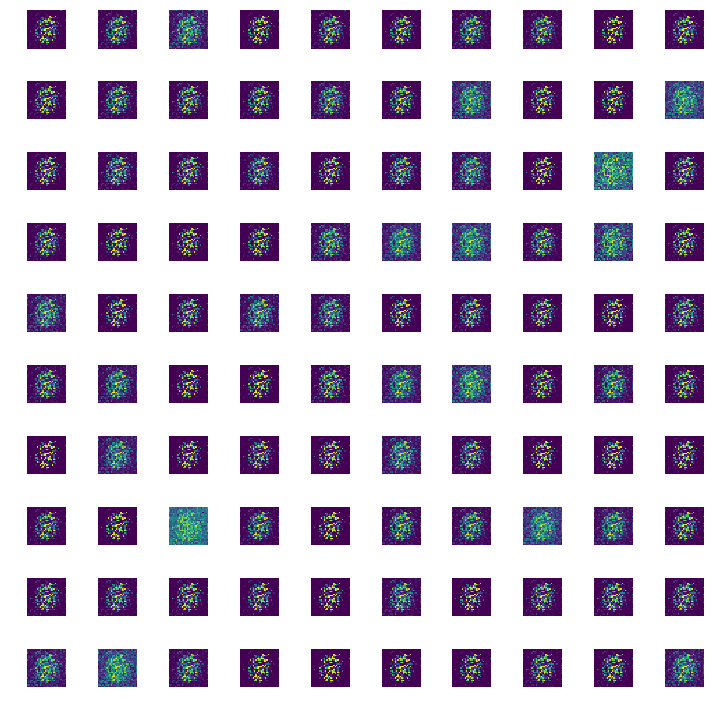

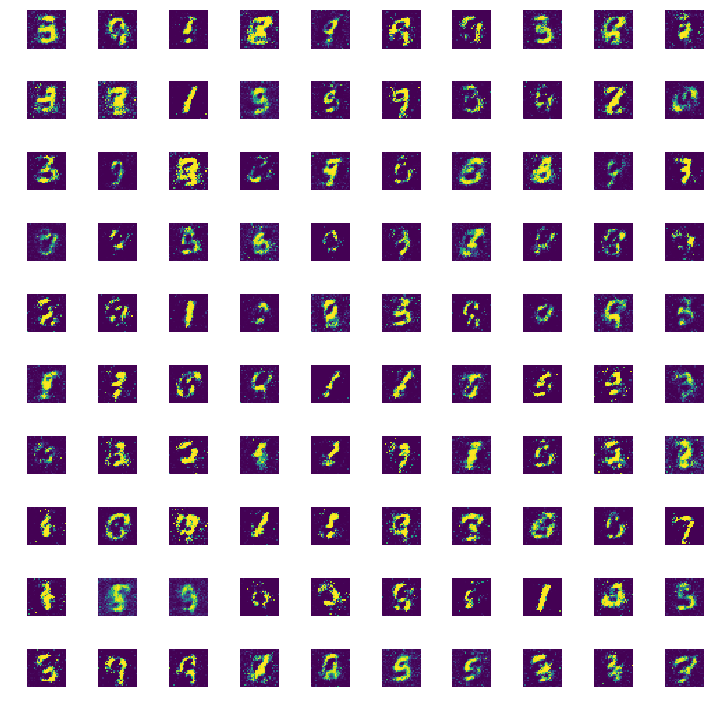

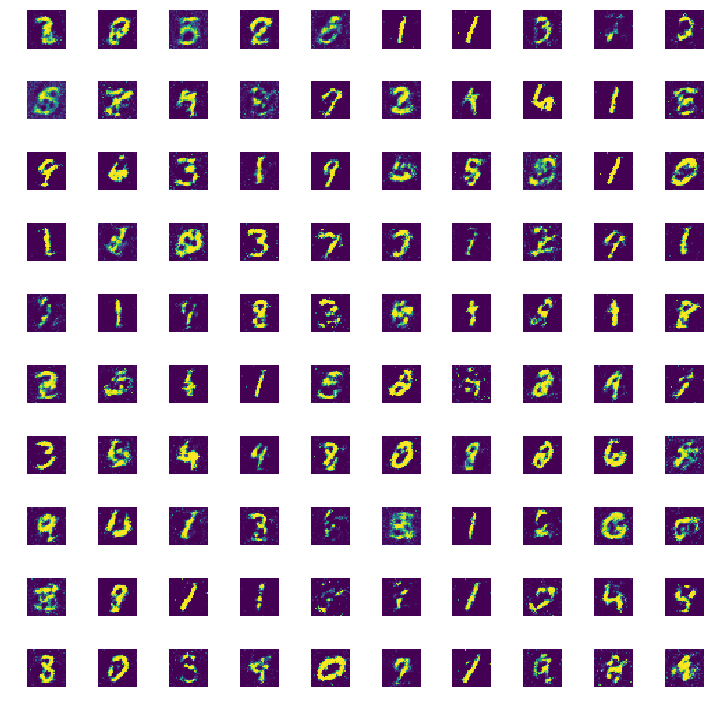

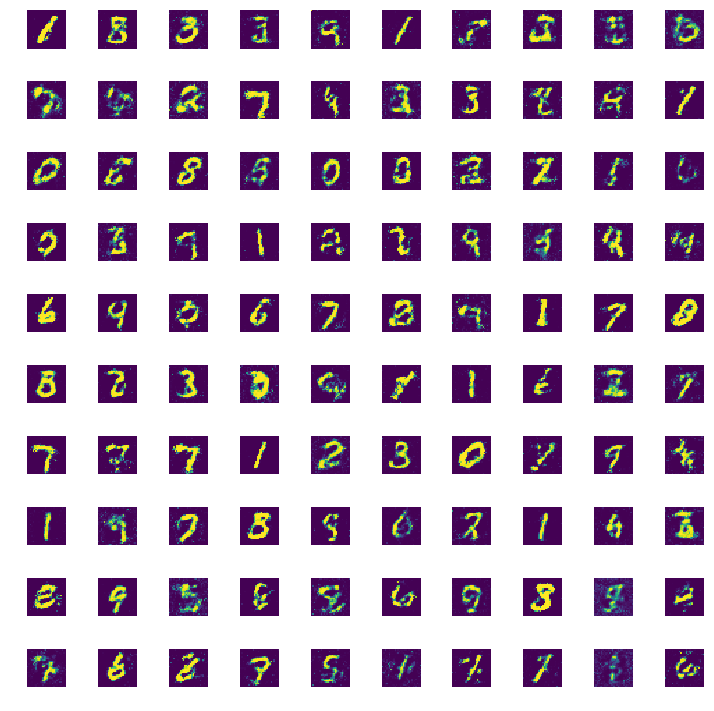

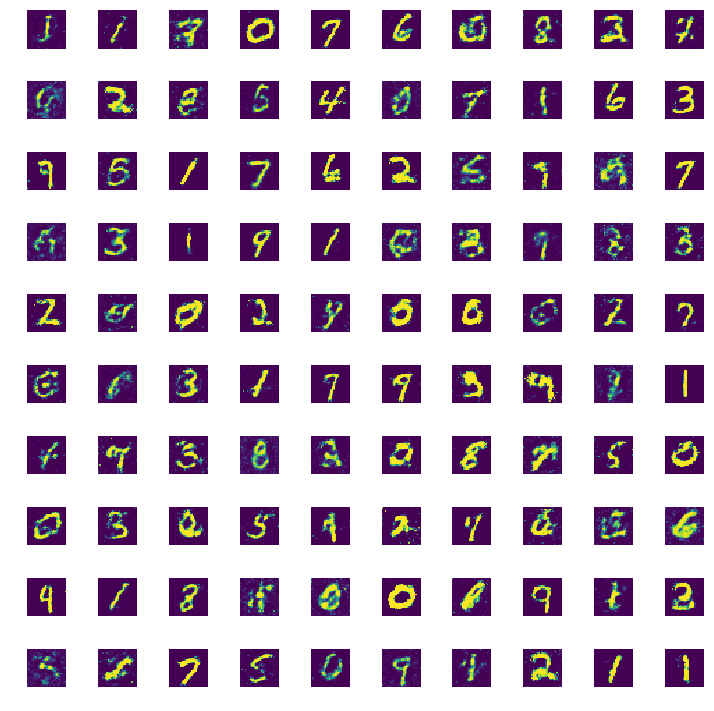

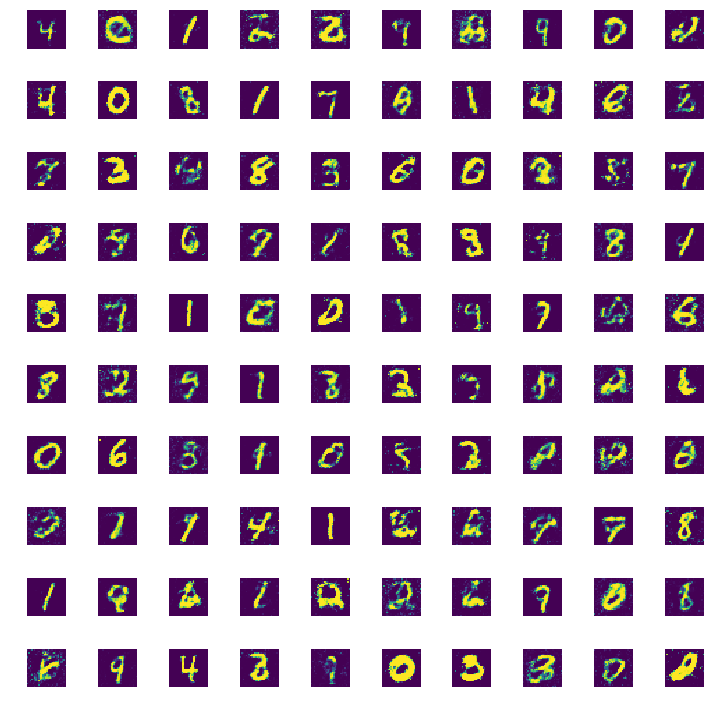

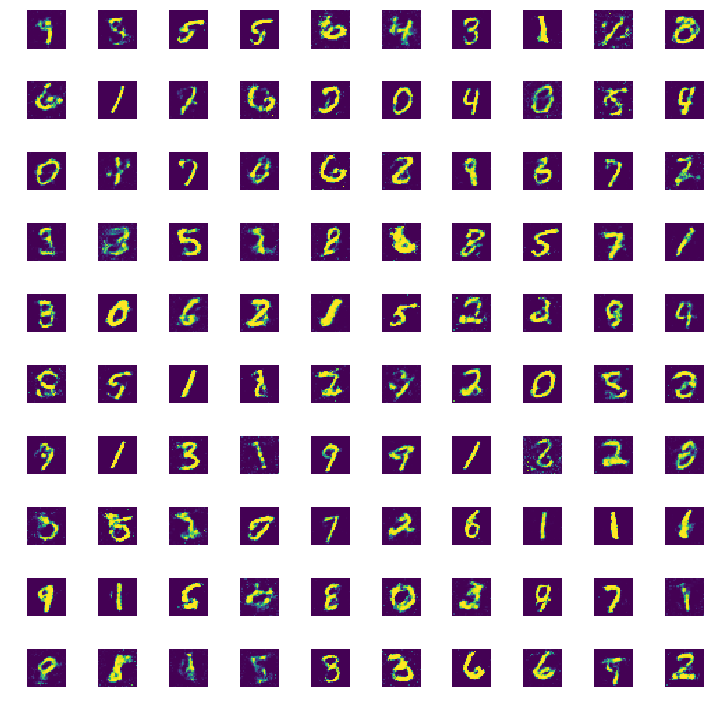

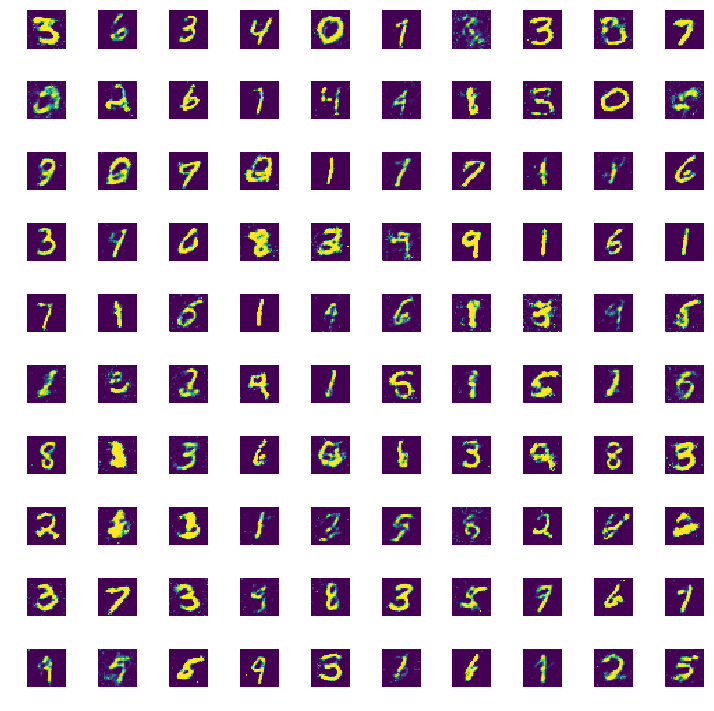

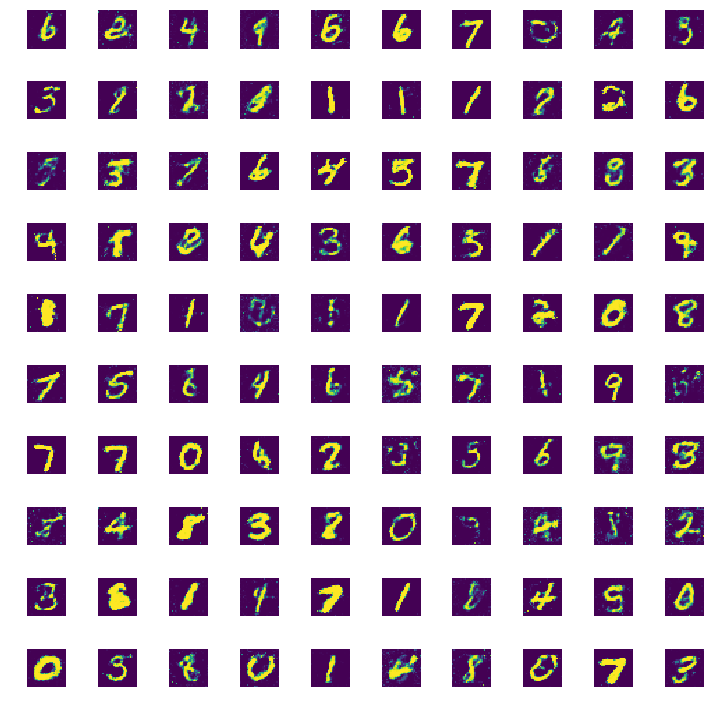

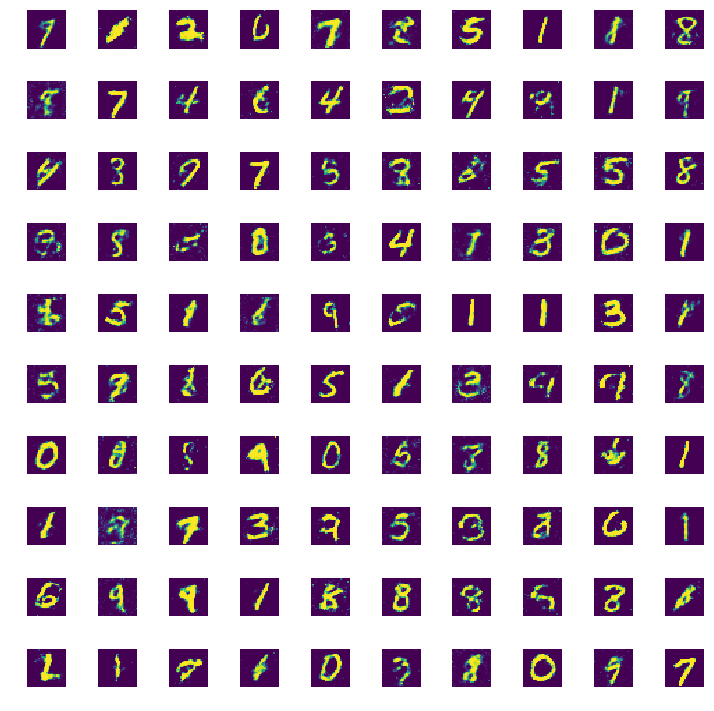

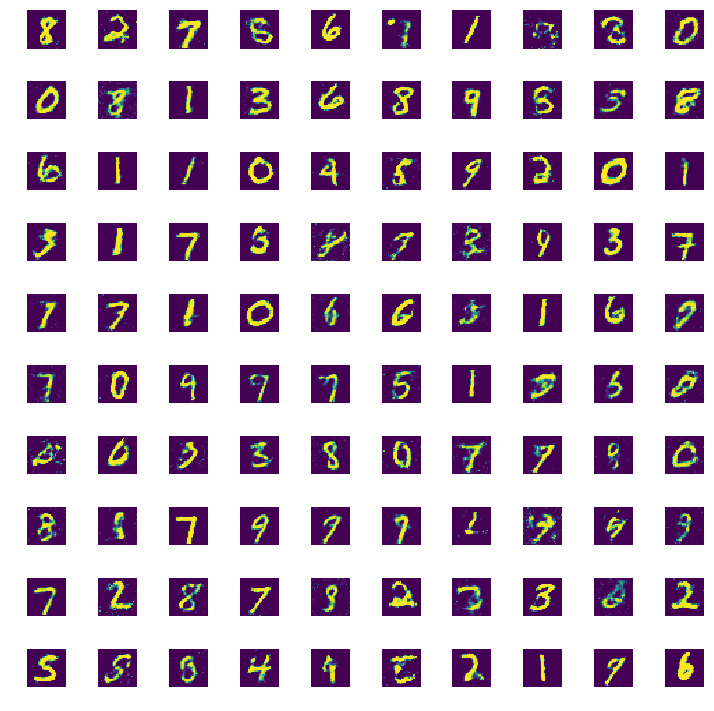

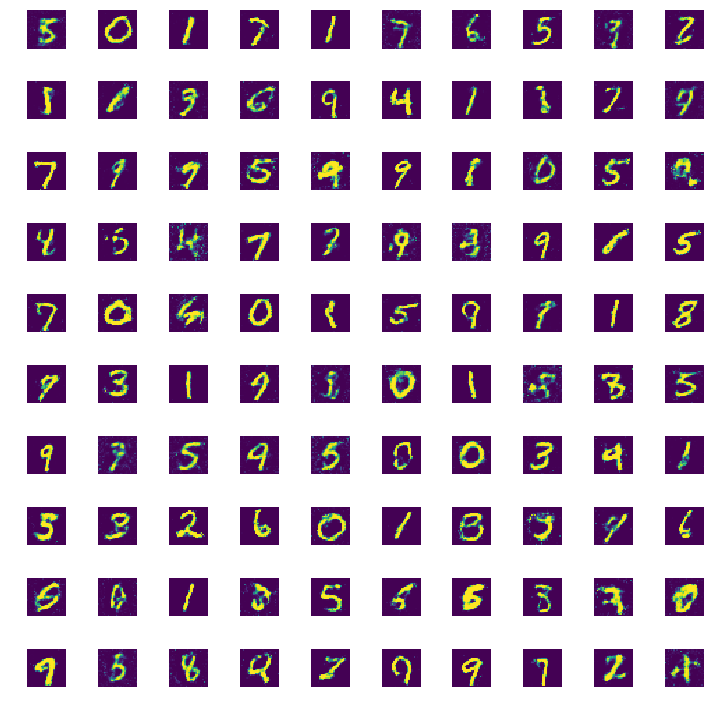

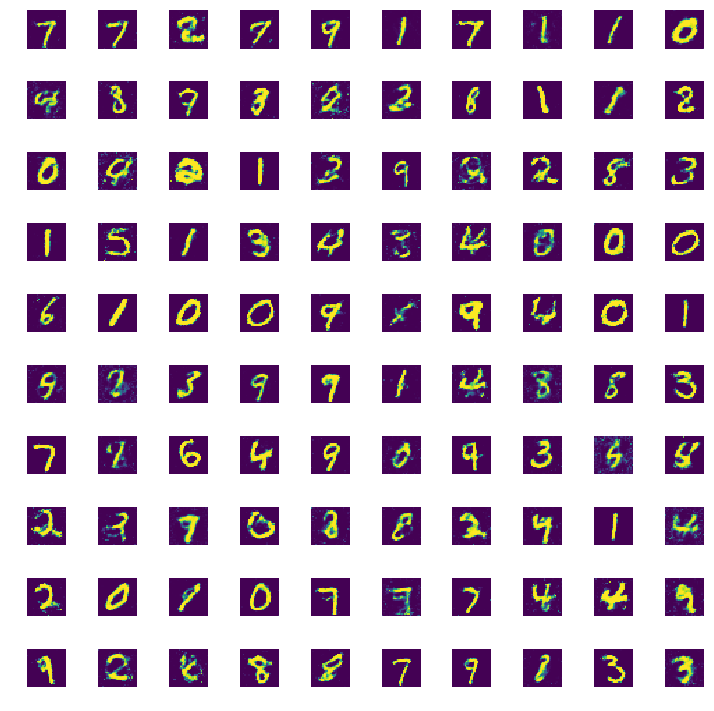

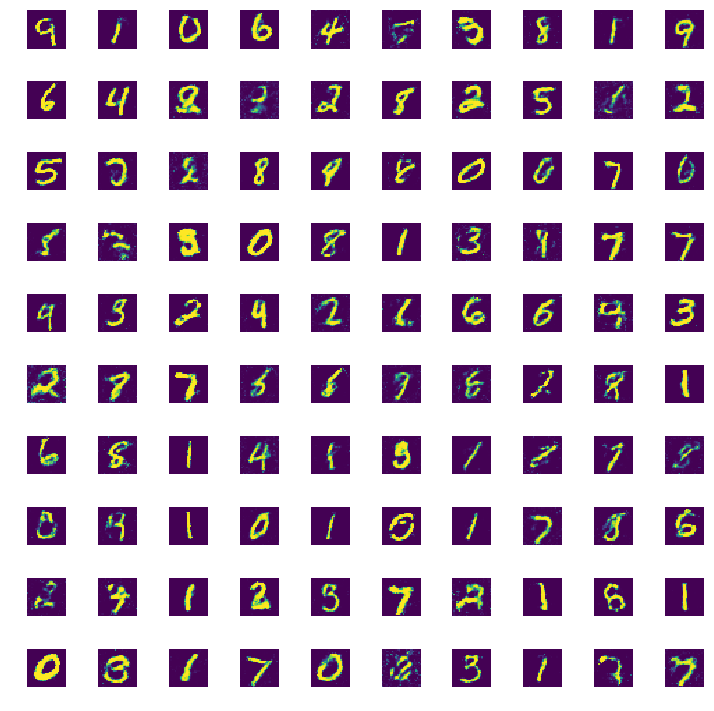

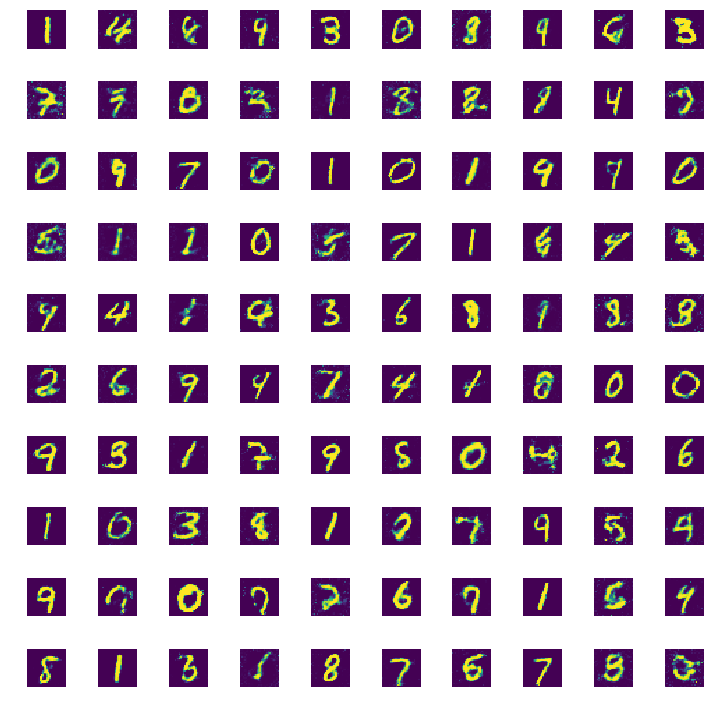

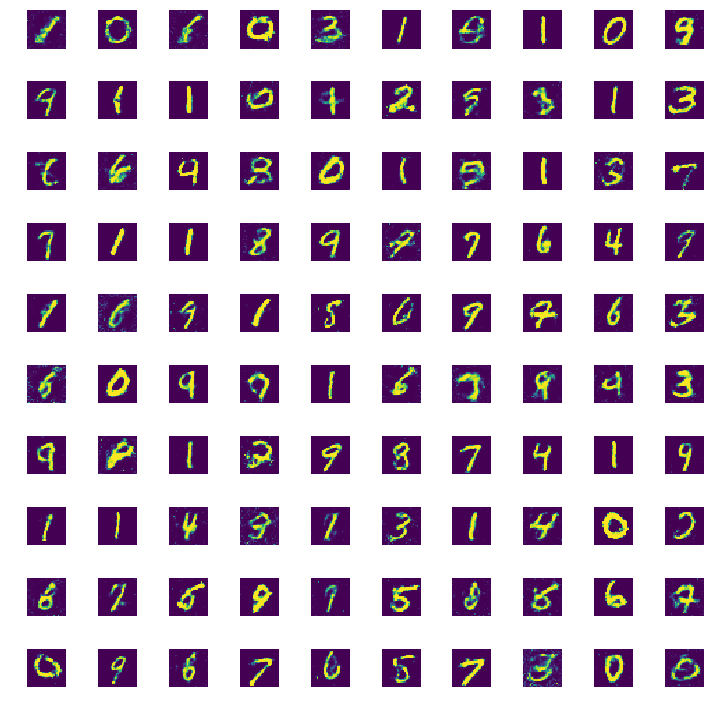

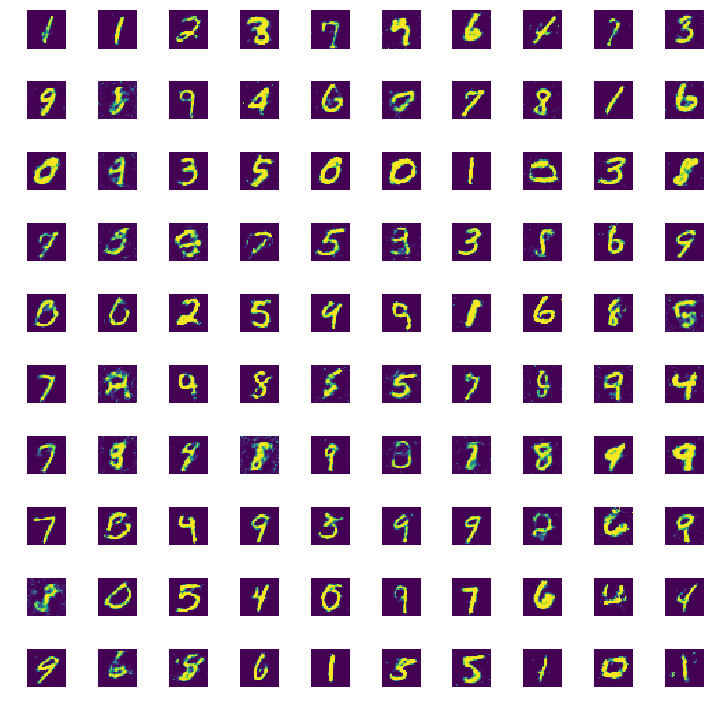

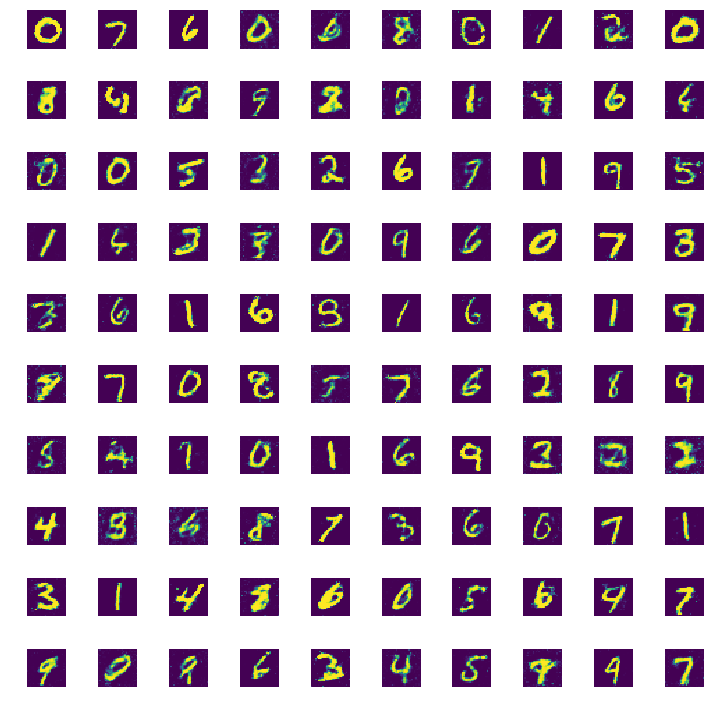

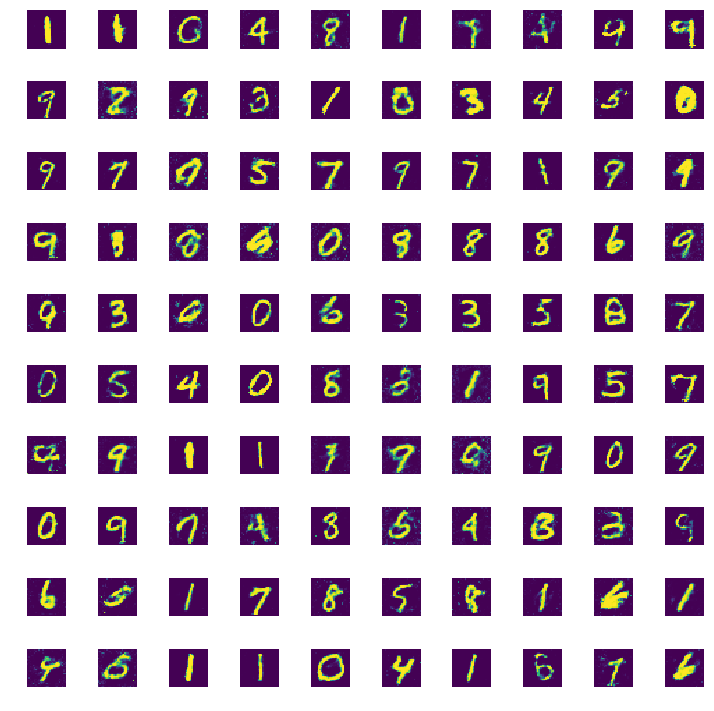

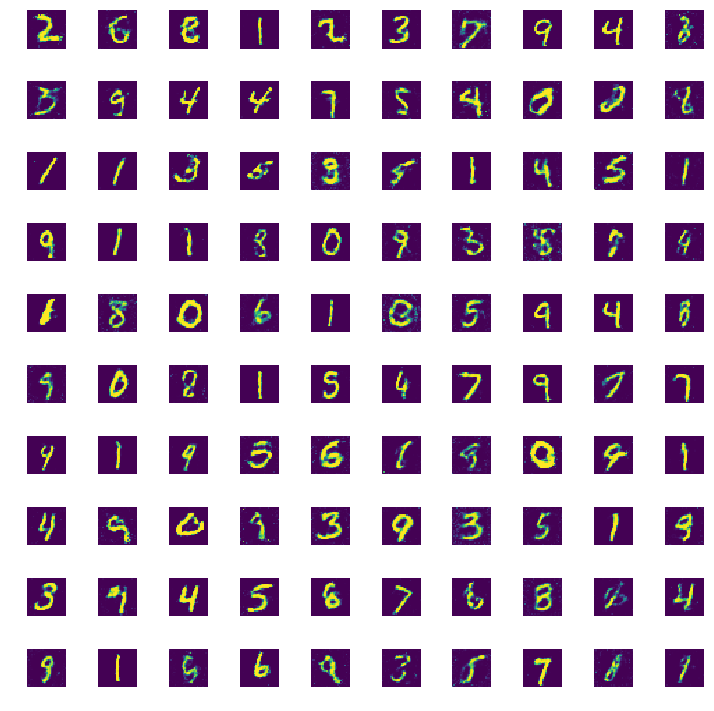

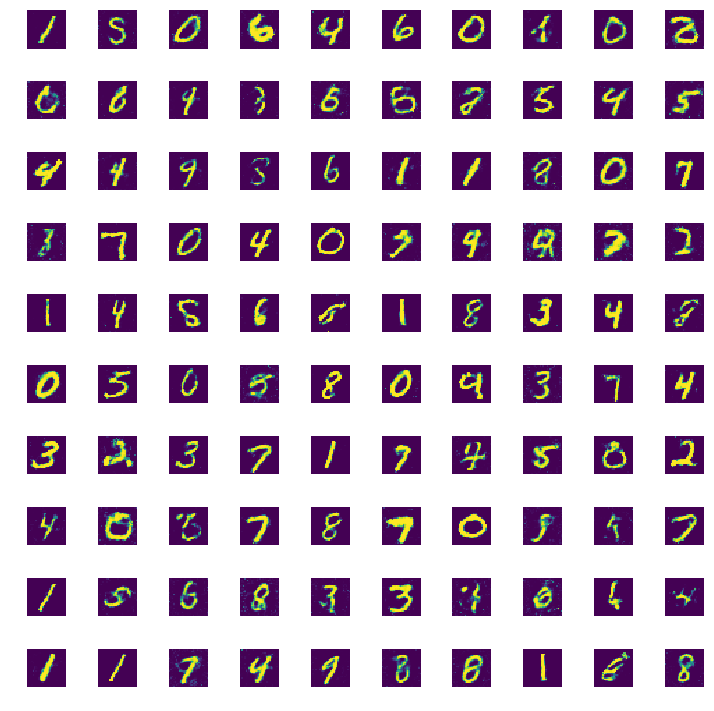

In [8]:
#alternate between training the discrimintator and the generator

def training(epochs=1, batch_size=128):
    
    #Loading the handwritten data
    (X_train, y_train, X_test, y_test) = load_data()
    #calculate how many batches there will be (training examples/batch size)
    batch_count = X_train.shape[0] / batch_size
    
    #Create GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    #epochs = the number of times you will cycle through your training data
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        #does the normal Keras progress bar not work so we need to use tqdm progress meter?
        #or is it the fact that we want to do things such as create images within the training that makes tqdm necessary?
        for _ in tqdm(range(batch_size)):
        #generate "random" noise as an input to seed the  generator
        #the dimension of the noise input doesn't need to match the dimension of the generated images
            noise= np.random.normal(0,1, [batch_size, 100]) #standard normal z values in a 128x100 matrix
            
            # Generate fake MNIST images from noised input
            # It is not really a Network for "Predicting" but it still is a feed forward net
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct a combined batch of  real and fake images
            #X has twice the batch_size
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            # why do the first labels get 0.9 instead of one hot encoding?(need to experiment)
            # i guess it may not matter, although there may not be incentive to predict with higher than .9 confidence?
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            #y_dis[:batch_size]=1
            
            #Step 1: Train discriminator
            #Train on fake and real images
            #If you imagine the GAN as one big network, we are just updating the second half of parameters here.
            #
            #One case when it might be nice to use "train_on_batch" instead of "fit" is...
            #when updating a pre-trained model on a single new batch of samples. 
            #Suppose you've already trained a model, but now you've received a new set of training samples 
            #You could use train_on_batch to update the existing model only on those samples. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Step 2: Train Generator
            #Now that the generator will be trained, the "ground truth" for improving the cost function is flipped
            #The generator will be rewarded if it can get the discrimintor to agree that the images are real
            #If you imagine the GAN as one big network, we are just updating the first half of parameters here,
            #But we are using the entire network, unlike the discrimintor training uses only the second half
            #And now our ground truths on the cost function is different
            noise = np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of the Generator part of the GAN the discriminator weights are fixed
            # Is this line redundant since create_gan function has same line? maybe not.
            discriminator.trainable=False
            
            #when the discriminator is fixed the generator part of chained GAN is training
            #the only way for the generator paramaters to improve the loss/cost function is
            #to create better ways of transforming the noise it gets as input into 784 grayscale pixel arrangentments
            #such that the second half of the network (discriminator) computes that these fake inputs are real
            gan.train_on_batch(noise, y_gen)
        
        #plot generated images at the start and then every 20 epochs
        #we'll only be able to see these at the end of training? not along the way?
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

#do 400 epochs of training with batch sizes of 128
#each epoch will first train/improve the discriminator
#then train and improve the generator
training(400,128)

In [ ]:
#if you finished the training, you should see pictures demonstrating how good are generator is at creating realistic looking images from noise
#we also probably have a pretty good discriminator at the end of training, if that's of interest to you
#question: what distribution of numbers does the generator produce? is it the same as the real MNIST training data distribution?
